In [1]:
# Import necessary packages. 
import numpy as np
import pylab as py
import os
import glob
import pdb
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from specutils import Spectrum1D
import stsynphot as stsyn  
import astropy.units as u
import math
from synphot import Observation
import pysynphot as S
global sig_int
import pandas as pd
from scipy import interpolate

os.chdir("/Users/alexgagliano/Documents/Research/2020oi/data/BPASS/BPASSv2.2.1_release-07-18-Tuatara/BPASSv2.2.1_bin-imf135_100")

/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Users/alexgagliano/Documents/Research/2020oi/scripts/SPISEA/models/grp/hst/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [2]:
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]

In [3]:
#taken from prospector -- photometry in maggies!
bands = np.array(['acs_wfc_f814w','wfc3_ir_f160w','wfc3_uvis_f475w','wfc3_uvis_f555w',\
                  'wfc3_uvis_f814w','acs_hrc_f814w','acs_hrc_f555w','acs_hrc_f330w','wfc3_uvis1_f775w'])

obs_wave = np.array([ 8005.60843049, 15324.46877726,  4736.37692621,  5256.11107939,\
        7972.96177452,  8037.98253126,  5331.73210482,  3354.03701153,\
        7630.74012291])

obs_mag = np.array([1.74164645e-08, 1.25233351e-08, 2.30038221e-08, 2.03967043e-08,
       1.48306437e-08, 1.25614565e-08, 2.03929474e-08, 2.76312161e-08,
       1.41227737e-08])
                   
obs_sig = np.array([3.20981202e-09, 2.31796209e-09, 4.24100791e-09, 3.76035704e-09,
       2.74140200e-09, 2.32393795e-09, 3.76452776e-09, 5.10368072e-09,
       2.62558331e-09])

In [4]:
obs_dict = {}
obs_err_dict = {}

obs_dict[bands[0]] = obs_mag[0]
obs_dict[bands[1]] = obs_mag[1]
obs_dict[bands[2]] = obs_mag[2]
obs_dict[bands[3]] = obs_mag[3]
obs_dict[bands[4]] = obs_mag[4]
obs_dict[bands[5]] = obs_mag[5]
obs_dict[bands[6]] = obs_mag[6]
obs_dict[bands[7]] = obs_mag[7]
obs_dict[bands[8]] = obs_mag[8]

obs_err_dict[bands[0]] = obs_sig[0]
obs_err_dict[bands[1]] = obs_sig[1]
obs_err_dict[bands[2]] = obs_sig[2]
obs_err_dict[bands[3]] = obs_sig[3]
obs_err_dict[bands[4]] = obs_sig[4]
obs_err_dict[bands[5]] = obs_sig[5]
obs_err_dict[bands[6]] = obs_sig[6]
obs_err_dict[bands[7]] = obs_sig[7]
obs_err_dict[bands[8]] = obs_sig[8]

bands = np.array(['acs_wfc_f814w','wfc3_ir_f160w','wfc3_uvis_f475w','wfc3_uvis_f555w',\
                  'wfc3_uvis_f814w','acs_hrc_f814w','acs_hrc_f555w','acs_hrc_f330w','wfc3_uvis1_f775w'])

cols_mag = np.array([
    obs_dict['acs_hrc_f330w']-obs_dict['wfc3_uvis_f555w'],
    obs_dict['acs_hrc_f330w']-obs_dict['wfc3_uvis1_f775w'],
    obs_dict['wfc3_uvis_f475w']-obs_dict['wfc3_uvis1_f775w'],
    obs_dict['wfc3_uvis_f555w']-obs_dict['wfc3_uvis1_f775w'],
    obs_dict['wfc3_uvis_f555w']-obs_dict['wfc3_uvis_f814w'],
    obs_dict['acs_hrc_f330w']-obs_dict['wfc3_ir_f160w'],
    obs_dict['wfc3_uvis_f555w']-obs_dict['wfc3_ir_f160w'],
    obs_dict['wfc3_uvis_f814w']-obs_dict['wfc3_ir_f160w']
])

cols_sig = np.array([
    obs_err_dict['acs_hrc_f330w']-obs_err_dict['wfc3_uvis_f555w'],
    obs_err_dict['acs_hrc_f330w']-obs_err_dict['wfc3_uvis1_f775w'],
    obs_err_dict['wfc3_uvis_f475w']-obs_err_dict['wfc3_uvis1_f775w'],
    obs_err_dict['wfc3_uvis_f555w']-obs_err_dict['wfc3_uvis1_f775w'],
    obs_err_dict['wfc3_uvis_f555w']-obs_err_dict['wfc3_uvis_f814w'],
    obs_err_dict['acs_hrc_f330w']-obs_err_dict['wfc3_ir_f160w'],
    obs_err_dict['wfc3_uvis_f555w']-obs_err_dict['wfc3_ir_f160w'],
    obs_err_dict['wfc3_uvis_f814w']-obs_err_dict['wfc3_ir_f160w']
])

In [7]:
cols_sig

array([1.34332368e-09, 2.47809741e-09, 1.61542460e-09, 1.13477373e-09,
       1.01895504e-09, 2.78571863e-09, 1.44239495e-09, 4.23439910e-10])

In [10]:
Age_arr = []
newNames = {}
newNames[0] = "Angstrom"

for i in np.arange(52): 
    Age_arr.append(10**(6.+0.1*((i+2)-2.)))
    newNames[i+1] = int(Age_arr[i])
    
def fit(theta):
    logAge = theta[0] 
    Z = theta[1]

    Age = 10**logAge

    metallicity = {0.001: '001', 0.002:'002', 0.003:'003', 0.004:'004', .006:'006', .008:'008', \
      0.010:'010', 0.014:'014', 0.020:'020', 0.030:'030',  0.040:'040', 1.e-4:'em4', 1.e-5:'em5'}
    metallicity_arr = [1.e-5, 1.e-4, 0.001, 0.002, 0.003, 0.004, 0.006, 0.008, 0.01, 0.014, 0.02, 0.03, 0.04]
 
    Z = find_nearest(metallicity_arr, Z)
    Age = find_nearest(Age_arr, Age)
    Zstr = metallicity[Z]
    fn = 'spectra-bin-imf135_100.z' + Zstr + '.dat'
    df = pd.read_csv(fn, delim_whitespace=True, header=None)
    df.rename(columns=newNames, inplace=True)
    wave = df['Angstrom'].values
    spec = df[int(Age)].values #Solar Luminosities per Angstrom, normalised for a cluster of 1e6
    # Msun formed in a single instantaneous burst.
    d = 5.277e25 #17.1 Mpc in cm 
    spec *=  3.848e26*1.e7/(4*np.pi*d**2)  #Lsun/A to erg/s/AA to erg/s/AA/cm^2
    spec = S.ArraySpectrum(wave, spec, fluxunits='flam')
    
    obs814_wfc =S.Observation(spec,S.ObsBandpass('acs,wfc1,f814w')).effstim('abmag')
    obs160_ir = S.Observation(spec,S.ObsBandpass('wfc3,ir,f160w')).effstim('abmag')
    obs475_uvis = S.Observation(spec,S.ObsBandpass('wfc3,uvis1,f475w')).effstim('abmag')
    obs555_uvis = S.Observation(spec,S.ObsBandpass('wfc3,uvis1,f555w')).effstim('abmag')
    obs814_uvis = S.Observation(spec,S.ObsBandpass('wfc3,uvis1,f814w')).effstim('abmag')
    obs814_hrc =S.Observation(spec,S.ObsBandpass('acs,hrc,f814w')).effstim('abmag')
    obs555_hrc =S.Observation(spec,S.ObsBandpass('acs,hrc,f555w')).effstim('abmag')
    obs330_hrc =S.Observation(spec,S.ObsBandpass('acs,hrc,f330w'),  force='extrap').effstim('abmag')    
    obs775_uvis = S.Observation(spec,S.ObsBandpass('wfc3,uvis1,f775w')).effstim('abmag')
    
    mags = np.array([obs814_wfc, obs160_ir, obs475_uvis, obs555_uvis, obs814_uvis, obs814_hrc, obs555_hrc, obs330_hrc, obs775_uvis])    
    #convert to maggies 
    sim_maggies = 10**(-0.4*mags)
    
    col_maggies = np.array([
        sim_maggies[7]-sim_maggies[3],
        sim_maggies[7]-sim_maggies[8],
        sim_maggies[2]-sim_maggies[8],
        sim_maggies[3]-sim_maggies[8],
        sim_maggies[3]-sim_maggies[4],
        sim_maggies[7]-sim_maggies[1],
        sim_maggies[3]-sim_maggies[1],
        sim_maggies[4]-sim_maggies[1]])

    return col_maggies
    

In [12]:
#fn = 'spectra-bin-imf135_100.z008.dat'
#df = pd.read_csv(fn, delim_whitespace=True, header=None)
metallicity_arr = [1.e-5, 1.e-4, 0.001, 0.002, 0.003, 0.004, 0.006, 0.008, 0.01, 0.014, 0.02, 0.03, 0.04]
logage_arr = np.linspace(6,11,51)
xx, yy = np.meshgrid(logage_arr, metallicity_arr)

c1 = xx.copy()
c2 = xx.copy()
c3= xx.copy()
c4 = xx.copy()
c5 = xx.copy()
c6 = xx.copy()
c7 = xx.copy()
c8 = xx.copy()

for i in np.arange(np.shape(xx)[0]):
        for j in np.arange(np.shape(xx)[1]):
            c1[i][j] = fit(np.array([xx[i][j], yy[i][j]]))[0]
            c2[i][j] = fit(np.array([xx[i][j], yy[i][j]]))[1]
            c3[i][j] = fit(np.array([xx[i][j], yy[i][j]]))[2]
            c4[i][j] = fit(np.array([xx[i][j], yy[i][j]]))[3]
            c5[i][j] = fit(np.array([xx[i][j], yy[i][j]]))[4]
            c6[i][j] = fit(np.array([xx[i][j], yy[i][j]]))[5]
            c7[i][j] = fit(np.array([xx[i][j], yy[i][j]]))[6]
            c8[i][j] = fit(np.array([xx[i][j], yy[i][j]]))[7]

In [13]:
from scipy.interpolate import RegularGridInterpolator
int_c1 = RegularGridInterpolator((metallicity_arr,logage_arr), c1)
int_c2 = RegularGridInterpolator((metallicity_arr,logage_arr), c2)
int_c3 = RegularGridInterpolator((metallicity_arr,logage_arr), c3)
int_c4 = RegularGridInterpolator((metallicity_arr,logage_arr), c4)
int_c5 = RegularGridInterpolator((metallicity_arr,logage_arr), c5)
int_c6 = RegularGridInterpolator((metallicity_arr,logage_arr), c6)
int_c7 = RegularGridInterpolator((metallicity_arr,logage_arr), c7)
int_c8 = RegularGridInterpolator((metallicity_arr,logage_arr), c8)

In [16]:
def fit_interp(theta):
    #hacky fix because I interpolated all my data in reverse order
    theta_r = np.flip(theta)
    
    #note -- these should all be zeros at the end!
    vals = np.array([int_c1(theta_r)[0],
                     int_c2(theta_r)[0],
                     int_c3(theta_r)[0],
                     int_c4(theta_r)[0],
                     int_c5(theta_r)[0],
                     int_c6(theta_r)[0],
                     int_c7(theta_r)[0],
                     int_c8(theta_r)[0]])
    return vals

In [23]:
sig_int = 0.0 #what sets the intrinsic dispersion??
def chi_sq(theta, obs, obs_err):    
    chisq = np.zeros(len(obs))
    for i in np.arange(len(chisq)):
        tempval = (fit_interp(theta)[i] - obs[i])**2/(obs_err[i]**2)
        chisq[i] = tempval 
    return np.sum(chisq)

def neg_log_likelihood(theta, obs, obs_err):    
#    """The log-likelihood function."""#
    return 0.5*chi_sq(theta, obs, obs_err)

def loglike(theta, obs, obs_err):    
#    """The log-likelihood function."""#
    return -0.5*chi_sq(theta, obs, obs_err)

In [25]:
run_Z = []
run_age = []
run_like = []
run_chisq = []

metallicity_arr = np.logspace(-4, -1.5,101)
logage_arr = np.linspace(6.1,11,101)

for i in np.arange(len(metallicity_arr)):
    for j in np.arange(len(logage_arr)):
        Z = metallicity_arr[i]
        logage = logage_arr[j]
        theta = np.array([logage, Z])
       # print(theta)
        run_chisq.append(chi_sq(theta, cols_mag, cols_sig))
        run_like.append(neg_log_likelihood(theta, cols_mag, cols_sig))
        run_Z.append(Z)
        run_age.append(logage)
        
run_Z = np.array(run_Z)
run_age = np.array(run_age)
run_like = np.array(run_like)
run_chisq = np.array(run_chisq)

resultDF = pd.DataFrame({'logAge':run_age, 'Z':run_Z, 'negLogLike':run_like, 'chi_sq':run_chisq})

In [26]:
resultDF.to_csv("/Users/alexgagliano/Documents/Research/2020oi/data/derived_data/BPASS_gridSearch_RegularGridInterp_Colors.csv",index=False)

In [27]:
resultDF[resultDF['chi_sq']==np.nanmin(resultDF['chi_sq'])]

,logAge,Z,negLogLike,chi_sq
36,7.864,0.0001,96.614085,193.228169


In [30]:
10**(7.864)/1.e9

0.07311390834834172

In [28]:
np.nanmin(resultDF['chi_sq'])

193.22816938579282

/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


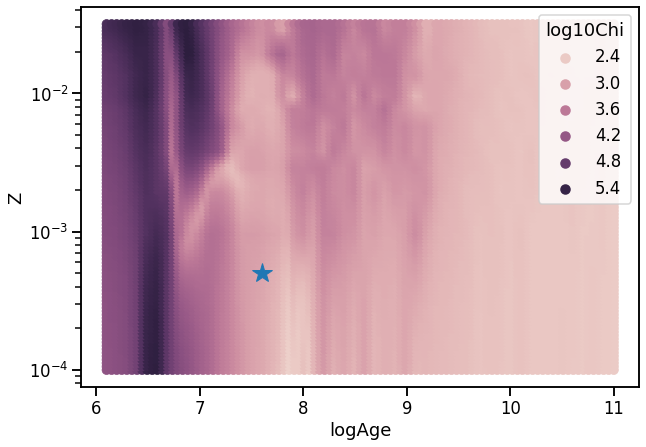

In [42]:
resultDF['Prob'] = np.exp(-resultDF['chi_sq'])
resultDF['log10Chi'] = np.log10(resultDF['chi_sq'])

sns.set_context("talk")

plt.figure(figsize=(10,7))
sns.scatterplot(resultDF['logAge'], resultDF['Z'], hue=resultDF['log10Chi'],edgecolor=None)
plt.plot(7.6, 0.0005,'*', ms=20, zorder=100)
plt.yscale("log")